In [1]:
from astropy.table import Table
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import statistics
from scipy import optimize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [2]:
t= Table.read('solar_twins_data.fits') #fits file as table 

In [3]:
#importing all data from condensation_temperature
from condensation_temperature import * 

get_tc('O'); #function that returns temp when given an element

#tc_map is a dictionary of elements : condensation temp
tc_map['O']; #accessing temp from element with tc_map

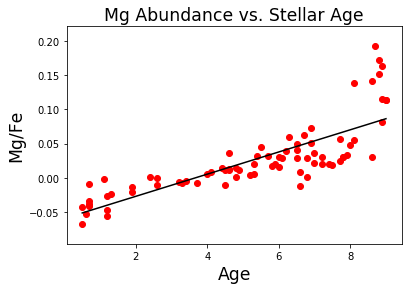

In [4]:
#plot of star age vs Mg abundance from above table - before removing temp trends
plt.scatter(t['age'], t['Mg'], c='r') 
plt.xlabel('Age',fontsize='xx-large')
plt.ylabel('Mg/Fe', fontsize='xx-large')
plt.title('Mg Abundance vs. Stellar Age', fontsize='xx-large')
plt.plot(np.unique(t['age']), np.poly1d(np.polyfit(t['age'], t['Mg'], 1))(np.unique(t['age'])), color='black')

In [5]:
#function that returns an table with an inputted star's elements, abundance, error and temp
def find_stellar_abundances(star):
    for i, txt in enumerate(t['star_name']):
        if txt == star:
            tbl = t[i] #inputted star's row
            tbl

    star_elements =[]
    elnames = tbl.columns[3:64]
    for n in elnames:
        if len(n) < 3 :
            star_elements.append(n)
            star_elements #list of elements in that star
    
    star_abundance = []
    for n in star_elements:
        star_abundance.append(tbl[n])
        star_abundance #list of element abundances
        
    star_con_temp = []
    for n in star_elements:
        star_con_temp.append(tc_map[n])
        star_con_temp #condensation temperatures for stellar elements
    
    star_error_elements = []
    for r in elnames:
        if len(r) > 3 :
            star_error_elements.append(r) #list of elements recorded in star

    el_error = []
    for k in star_error_elements:
        el_error.append(tbl[k])
        el_error #list of error values for elements
    
    star_table = Table([star_elements, star_abundance, el_error, star_con_temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp')) #table of temperature vs abundance for elements 
    return star_table

In [6]:
#function for returning the best slope and intercept using linear algebra
#[m b] = [A^T C^-1 A]^-1 [A^T C^-1 Y]
def find_m_b(x,y,err):
    errorsq = np.square(err)
    C = np.diag(errorsq)
    xb = ([1] * len(x))
    mata = []
        
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
            
    A= np.matrix(mata).reshape((len(x), 2))
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)
        
    m_= float(cov[0])
    b_= float(cov[1])
    return m_,b_ 

In [7]:
#jackknife method for determining other possible values of m and b 
def jackknifemb(_tp,_ab,_er):
    N=1000
    l=list(np.copy(_tp))
    k=list(np.copy(_ab))
    s=list(np.copy(_er))
    jackm= []
    jackb= [] 
    h=0
    
    #leaving out one point from data set and calculating m, b for each instance
    while h<N:
        w = random.randint(0, 29)
        del l[w]
        del k[w]
        del s[w] #removing one data set from lists 
    
        jk_mb = find_m_b(l,k,s)
        jk_m = jk_mb[0]
        jk_b = jk_mb[1]

        jackm.append(jk_m)
        jackb.append(jk_b)
            
        l=list(np.copy(_tp))
        k=list(np.copy(_ab))
        s=list(np.copy(_er))
        h=h+1 
        
    return jackm, jackb

In [8]:
def stellar_abundance_plot(star): 
    for i, txt in enumerate(t['star_name']):
        if txt == star:
            tbl = t[i] #inputted star's row
            tbl

    star_elements =[]
    elnames = tbl.columns[3:64]
    for n in elnames:
        if len(n) < 3 :
            star_elements.append(n)
            star_elements #list of elements in that star
    
    star_abundance = []
    for n in star_elements:
        star_abundance.append(tbl[n])
        star_abundance #list of element abundances
        
    star_con_temp = []
    for n in star_elements:
        star_con_temp.append(tc_map[n])
        star_con_temp #condensation temperatures for stellar elements
    new=np.array(star_con_temp)
    
    star_error_elements = []
    for r in elnames:
        if len(r) > 3 :
            star_error_elements.append(r)

    el_error = []
    for k in star_error_elements:
        el_error.append(tbl[k])
        el_error #list of error values for elements
    
    star_table = Table([star_elements, star_abundance, el_error, star_con_temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp'))

    #plt.scatter(star_con_temp, star_abundance)
    #plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
    #plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
    #plt.title('Temperature vs Element Abundance for {0}'.format(star), fontsize= 'xx-large', family='sans-serif')

    #point labels
    for i, txt in enumerate(elements):
            plt.annotate(txt, xy=(star_con_temp[i], star_abundance[i]), xytext=(-13,-6), 
                textcoords='offset points', ha='center', va='bottom')
            
    jk= jackknifemb(star_con_temp, star_abundance, el_error)
    for i, txt in enumerate (jk[0]):
        plt.scatter(temp, abundance)
        plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
        plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
        plt.title('Temperature vs Element Abundance', fontsize= 'xx-large', family='sans-serif')

        temparray=np.array(temp)
        plot_xs = np.arange(0, 1750, .1)
        plt.plot(plot_xs, jk[0][i] * plot_xs + (jk[1][i]), color = 'lightgray', linewidth=0.1)
    
    #error bars
    plt.errorbar(star_con_temp, star_abundance, yerr= el_error, fmt='o', color='black',
                 ecolor='lightsteelblue', elinewidth=3,capsize=0)
    
    #line of best fit m,b values
    errorsq = np.square(el_error)
    C = np.diag(errorsq)
    xb = ([1] * len(star_con_temp))
    mata = []
        
    for z, txt in enumerate(star_con_temp):
        mata.append(star_con_temp[z])
        mata.append(xb[z])
            
    A= np.matrix(mata).reshape((len(star_con_temp), 2))
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, star_abundance)).T
    mb = np.dot(invpt1, pt2)
        
    mb = find_m_b(star_con_temp, star_abundance, el_error)    
    plot_xs = np.arange(1750)
    plt.plot(plot_xs, (mb[0]) * plot_xs + (mb[1]), color='teal') 
    

    return plt

In [9]:
#chi squared :  [Y - AX]^T C^-1 [Y - AX]
def chisquared(param, x, y, erro): 
    ab = ([1] * len(x))
    Amat = []
    for z, txt in enumerate(x):
        Amat.append(x[z])
        Amat.append(ab[z])  
    A= np.array(Amat).reshape((len(x), 2))

    errorsq = np.square(erro)
    C = np.diag(errorsq)
    invsC = np.linalg.inv(C)

    AT= np.transpose(A)
    part1 = np.dot(AT, np.dot(invsC, A))
    invprt1= np.linalg.inv(part1)
    part2 = np.dot(AT, np.dot(invsC, y)).T
    X = np.dot(invprt1, part2)
    [X[0], X[1]] = param
    AX = np.dot(A,X)
    
    yax = (Y - AX)
    yaxT = np.transpose(yax)
    yaxTinvsC = np.dot(yaxT, invsC)

    chisq = (np.dot(yaxTinvsC, yax))
    return (chisq)

In [10]:
#creating a table of only one selected star
HIP10175_tbl = t[0] 
HIP10175_tbl;

In [11]:
#accessing only the element columns in the selected star's table and adding them to a list
elements =[]
tablenames = HIP10175_tbl.columns[3:64]
for n in tablenames:
    if len(n) < 3 :
        elements.append(n)
    elements

In [12]:
#list of abundances, in the same order as the elements list
abundance = []
for n in elements:
    abundance.append(HIP10175_tbl[n])
abundance;

In [13]:
#list of condensation temps, in the same order as the elements list
temp = []
for n in elements:
    temp.append(tc_map[n])
temp;

In [14]:
#list of element_err
error_elements = []
for r in tablenames:
    if len(r) > 3 :
        error_elements.append(r)

In [15]:
#list of error values for elements
error = []
for k in error_elements:
    error.append(HIP10175_tbl[k])
error;

In [16]:
#table of element, abundance and temperature
from astropy.table import Table
HIP10175_table = Table([elements, abundance, error, temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp'))

In [17]:
#test for HIP10175
m_b = find_m_b(temp,abundance,error)
print(m_b)

(9.441261972252866e-05, -0.12154306680819207)


#plotting values for star temp and abundance
plt.scatter(temp, abundance)
plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
plt.title('Temperature vs Element Abundance', fontsize= 'xx-large', family='sans-serif')
    
#point labels
for i, txt in enumerate(elements):
    if txt == 'Y' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
           textcoords='offset points', ha='center', va='bottom')
    elif txt == 'Co' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
            textcoords='offset points', ha='center', va='bottom') 
    else : 
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(-13,-6), 
            textcoords='offset points', ha='center', va='bottom')

#error bars
plt.errorbar(temp, abundance, yerr= error, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3,capsize=0)
m= m_b[0]
b= m_b[1]

temparray=np.array(temp)
plot_xs = np.arange(1750)
plt.plot(plot_xs, m * plot_xs + b, color='teal')

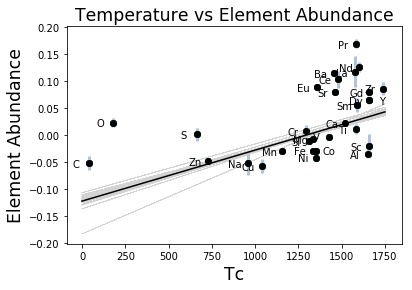

In [22]:
#plotting the various lines of best fit found using the jackknife method
jk= jackknifemb(temp, abundance, error)
for i, txt in enumerate (jk[0]):
    plt.scatter(temp, abundance)
    plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
    plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
    plt.title('Temperature vs Element Abundance', fontsize= 'xx-large', family='sans-serif')

    temparray=np.array(temp)
    plot_xs = np.arange(0, 1750, .1)
    plt.plot(plot_xs, jk[0][i] * plot_xs + (jk[1][i]), color = 'lightgray', linewidth=0.1)

for i, txt in enumerate(elements):
    if txt == 'Y' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
            textcoords='offset points', ha='center', va='bottom')
    elif txt == 'Co' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
            textcoords='offset points', ha='center', va='bottom') 
    else : 
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(-13,-6), 
            textcoords='offset points', ha='center', va='bottom')
        
mb= find_m_b(temp,abundance, error)
m = mb[0]
b= mb[1]

#error bars
plt.errorbar(temp, abundance, yerr= error, fmt='o', color='black',
                    ecolor='lightsteelblue', elinewidth=3,capsize=0)
plt.plot(plot_xs, m * plot_xs + b, color='black')

In [ ]:
#histogram of the intercept values found with jackknife
x = jk[1]
plt.hist(x, color = 'teal')
plt.ylabel('weight')
plt.xlabel('value')
plt.title('intercept values')
print('original value =', b)

In [ ]:
#histogram of the slope values found with jackknife 
x = jk[0]
plt.hist(x, color = 'green')
plt.ylabel('weight')
plt.xlabel('value')
plt.title('slope values')
print('original value = ', m)

In [ ]:
#standard slope error : [A^T C^-1 A]^-1
errorsq = np.square(error)
errorC = np.diag(errorsq)
abu = ([1] * len(temp))
atemper = np.copy(temp)
matri = []
        
for z, txt in enumerate(atemper):
    matri.append(atemper[z])
    matri.append(abu[z])
            
aa= np.matrix(matri).reshape((len(temp), 2))
Att = np.transpose(aa)
inverrorC = np.linalg.inv(errorC)
prt1 = np.dot(Att, np.dot(inverrorC,aa))
invt1= np.linalg.inv(prt1)
prt2 = np.dot(Att, np.dot(inverrorC, abundance)).T
covar = np.dot(invt1, prt2)
        
_m_= float(covar[0])
_b_= float(covar[1]) #standard slope, intercept values found with linalg 
    
inbrackets = np.dot(Att, np.dot(inverrorC, aa))
sserror = np.linalg.inv(inbrackets)
#sserror = [σ^2m, σmb, σmb, σ^2b]
sse = np.sqrt(sserror[0,0]) #standard slope error
sie = np.sqrt(sserror[1,1]) #standard intercept error

In [ ]:
#standard deviation without outliers
m_nooutliers = []
for p in jk[0]:
    if p < 0.00013:
        m_nooutliers.append(p)
        
b_nooutliers = []
for p in jk[1]:
    if p > -0.17:
        b_nooutliers.append(p)

In [ ]:
error_type = ['slope', 'intercept']
a = [m, b]
c = [statistics.stdev(jk[0]),statistics.stdev(jk[1])]
bv = [statistics.stdev(m_nooutliers), statistics.stdev(b_nooutliers)]
d = [np.sqrt(sserror[0,0]),np.sqrt(sserror[1,1])]
z = Table([error_type,a, c, bv, d], names=('error type', 'value','standard dev with outliers', 
                                          'standard dev without outliers',  'linear algebra uncertainty'))
z 

In [ ]:
x0 = [9e-5,.1]
res = scipy.optimize.minimize(chisquared, x0, args=(temp, abundance, error))
res

for u in t['star_name']:
    plt.figure()
    stellar_abundance_plot(u)
  #takes up too much computer space !!!!!!!!

stellar abundance plot only needs t, star's name but has to be updated to include alternate values for m,b from jackknife 

error and chi squared need to be condensed into a singular readable format, probably in plot function , alternatively in list/table form separate from plot 